In [27]:
from matplotlib import pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import sys
sys.path.append('../utils')
from helpers import real_gdp_df

plt.style.use('Solarize_Light2')

- **Load GDP data**

In [28]:
GDP_df = real_gdp_df()

# **CPIAUCSL**

- **Load CPIAUCSL data**

In [29]:
CPIAUCSL_df = pd.read_csv('data/CPIAUCSL.csv')

CPIAUCSL_df['DATE'] = pd.to_datetime(CPIAUCSL_df['DATE'])
CPIAUCSL_df.set_index('DATE', inplace=True)

CPIAUCSL_df['^ %'] = CPIAUCSL_df['CPIAUCSL'].pct_change()

CPIAUCSL_df.tail()

,CPIAUCSL,^ %
DATE,,
2024-06-01,313.049,-0.000562
2024-07-01,313.534,0.001549
2024-08-01,314.121,0.001872
2024-09-01,314.686,0.001799
2024-10-01,315.454,0.002441


- **Average change**

In [30]:
print(f"Average change is {CPIAUCSL_df['^ %'].mean() * 100}%")

Average change is 0.2889828295147166%


- **Overview on change**

In [31]:
positive_filter = CPIAUCSL_df['^ %'] > 0
negative_filter = CPIAUCSL_df['^ %'] < 0
zero_filter = CPIAUCSL_df['^ %'] == 0

# count
total_items = len(CPIAUCSL_df)

# average change
avg_change = [
    CPIAUCSL_df[positive_filter]['^ %'].mean(),
    CPIAUCSL_df[negative_filter]['^ %'].mean(),
    0,
    ""
]

# frequency
frequency = [
    CPIAUCSL_df[positive_filter]['^ %'].count(),
    CPIAUCSL_df[negative_filter]['^ %'].count(),
    CPIAUCSL_df[zero_filter]['^ %'].count()
]
frequency.append(frequency[0]/frequency[1])

# frequency pct
frequency_pct = [100 * frequency[i]/total_items for i in range(3)]
frequency_pct.append("")

# Prob adj
prob_adj = [frequency_pct[i] * avg_change[i] for i in range(3)]
prob_adj.append("")

pd.DataFrame({
    "%": [x * 100 for x in avg_change],
    "Frequency": frequency,
    "Frequency %": frequency_pct,
    "Prob Adjust % Change": prob_adj,
}, index=["Av Pos", "Av Neg", "Zero", "Ratio P/N"])

,%,Frequency,Frequency %,Prob Adjust % Change
Av Pos,0.37391,784.000000,83.940043,0.31386
Av Neg,-0.217819,108.000000,11.563169,-0.025187
Zero,0,41.000000,4.389722,0.0
Ratio P/N,,7.259259,,


- **Stats**

In [32]:
from scipy.stats import describe

# Display the results

stats = describe(CPIAUCSL_df['^ %'].dropna().tolist())
pd.DataFrame(
    {
        'value': [
            str(stats.nobs),
            stats.minmax[0] * 100,
            stats.minmax[1] * 100,
            stats.mean * 100,
            CPIAUCSL_df['^ %'].median() * 100,
            CPIAUCSL_df['^ %'].mode(dropna=True)[0] * 100,
            stats.variance,
            stats.skewness,
            stats.kurtosis
        ]
    },
    index=['nobs', 'Min %', 'Max %', 'Mean %', "Median %", "Mode %", 'Variance', 'Skewness', 'Kurtosis'],
)

,value
nobs,933
Min %,-1.770548
Max %,1.964286
Mean %,0.288983
Median %,0.246914
Mode %,0.0
Variance,0.000012
Skewness,0.590227
Kurtosis,4.022409


- **Data preview**

In [33]:
# Define bins
bins = [0.005 * i for i in range(-3, 4)]
bins.append(stats.minmax[1])
bins.insert(0, stats.minmax[0])
bin_labels = [f"{bins[i] * 100}% to {bins[i+1] * 100}%" for i in range(len(bins) - 1)]
bin_labels[0] = f"Less than {bins[1] * 100}%"
bin_labels[-1] = f"Greater than {bins[-2] * 100}%"

# Assign data to bins
binned = pd.cut(CPIAUCSL_df['^ %'], bins=bins, labels=bin_labels, include_lowest=True)

# Calculate frequency, probability, and cumulative probability
frequency = binned.value_counts().sort_index()
probability = 100 * frequency / frequency.sum()
cumulative_probability = probability.cumsum()

occurrence_frequencies = pd.DataFrame({
    'Frequency': frequency.values,
    'Probability %': probability.values,
    'Cumulative Probability %': cumulative_probability.values
}, index=bin_labels)

occurrence_frequencies

,Frequency,Probability %,Cumulative Probability %
Less than -1.5%,1,0.107181,0.107181
-1.5% to -1.0%,0,0.000000,0.107181
-1.0% to -0.5%,9,0.964630,1.071811
-0.5% to 0.0%,139,14.898178,15.969989
0.0% to 0.5%,591,63.344051,79.314041
0.5% to 1.0%,157,16.827438,96.141479
1.0% to 1.5%,29,3.108253,99.249732
Greater than 1.5%,7,0.750268,100.000000


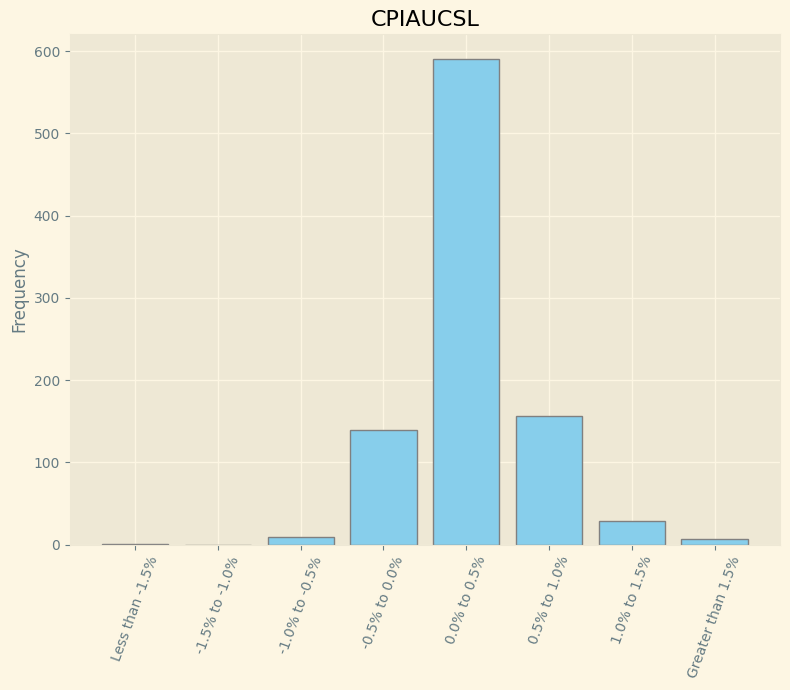

In [34]:
plt.figure(figsize=(8, 7))

plt.bar(occurrence_frequencies.index, occurrence_frequencies['Frequency'], color='skyblue', edgecolor='gray')

# median_age = df['^ %'].median()
# plt.axvline(median_age, color='#fc4f30', label='Change Median')

# Add labels and title
plt.title('CPIAUCSL')
plt.xlabel('')
plt.ylabel('Frequency')
plt.xticks(rotation=70) 
# Show the chart
plt.tight_layout()
plt.show();

- CPIAUCSL pct change

In [35]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=CPIAUCSL_df.index, 
    y=[100 * stats.mean] * (stats.nobs + 1), 
    name='PMI 50 Points',
    line=dict(width=2),
    hoverinfo="skip",
    showlegend=False,
    marker=dict(color='red'),
))

fig.add_trace(go.Bar(
    x=CPIAUCSL_df.index,
    y=CPIAUCSL_df['^ %'] * 100,
    name='CPIAUCSL',
    marker=dict(line=dict(color='rgba(0, 0,250, .9)', width=2)),
    width=0.5,
))

fig.update_layout(
    title=dict(text='CPIAUCSL pct change'),
    plot_bgcolor='rgb(230, 230,230)',
    width=1400,
    height=700,
    yaxis=dict(title="%", exponentformat="none", showgrid=False),
    barmode="group",
    xaxis=dict(showgrid=False),
)

fig.show()

- **CPIAUCSL data plot**

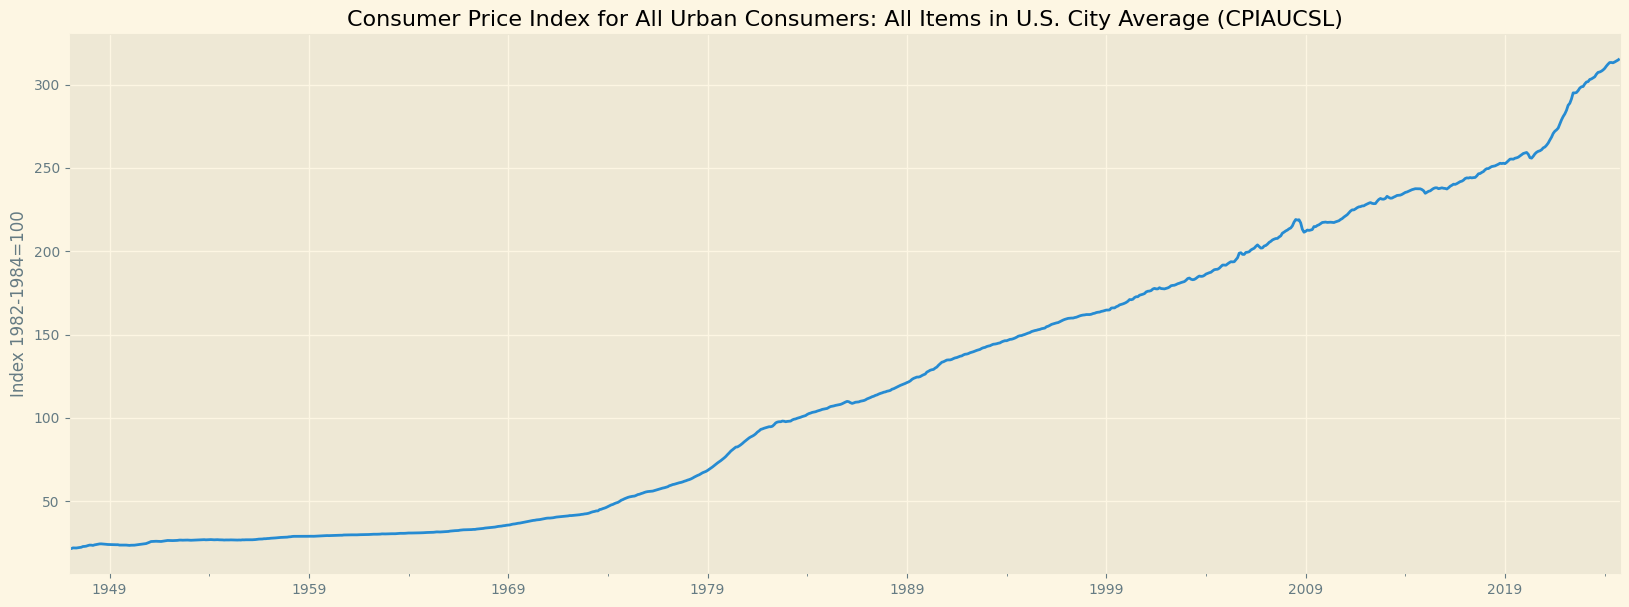

In [36]:
CPIAUCSL_df['CPIAUCSL'].plot(
    figsize=(20, 7),
    xlabel='',
    ylabel='Index 1982-1984=100',
    title='Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCSL)',
);

- **CPIAUCSL vs GDP Growth**

In [37]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=CPIAUCSL_df.index,
    y=CPIAUCSL_df['^ %'] * 100,
    name='CPIAUCSL',
    fill='tonexty',
    fillcolor='rgba(109,215,253, 0.9)',
    line=dict(color='rgba(109,215,253, 0.9)', width=1),
))

fig.add_trace(go.Bar(
    x=GDP_df.index,
    y=GDP_df['GDP'],
    name='GDP',
    marker=dict(color='red'),
    yaxis="y2"  
))

# ------------------------------------------------------------------------
level_a = 0  # Level on left y-axis
level_b = 0  # Matching level on right y-axis

# Define the ranges for each axis
range_left = [(CPIAUCSL_df['^ %'] * 100).min() - .25, (CPIAUCSL_df['^ %'] * 100).max() + .25]  # Min and max for right y-axis (to be adjusted)
range_right = [GDP_df['GDP'].min() - 5, GDP_df['GDP'].max() + 5]  # Min and max for left y-axis

# Calculate scaling factor to align levels
proportion = (level_a - range_left[0]) / (range_left[1] - range_left[0])  # Position of level_a
range_right[1] = range_right[0] + (level_b - range_right[0]) / proportion  # Adjust right range
# ------------------------------------------------------------------------

fig.update_layout(
    title=dict(text='CPIAUCSL vs GDP Growth'),
    plot_bgcolor='rgb(0, 0, 0)',
    width=1400,
    height=700,
    # hovermode="y unified",
    yaxis=dict(title="CPIAUCSL pct change %", exponentformat="none", range=range_left, showgrid=False),
    yaxis2=dict(title="Real GDP change in %", overlaying="y", side="right", range=range_right, showgrid=False),
    barmode="group",
    legend=dict(x=0.5, y=-0.2, orientation="h"),
    xaxis=dict(showgrid=False),
)

fig.show()